In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision as tv
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from PIL import Image
from tqdm import tqdm
import os


# NIH CXR14

In [2]:
NIH_CXR14_dataset = "/public_bme/data/lds/CXR_datasets/NIH_chest14_dataset"
NIH_CXR14_PATH = "/public_bme/data/lds/CXR_datasets/NIH_chest14_dataset/Data_Entry_2017_v2020.csv"
NIH_CXR14_images = "/public_bme/data/lds/CXR_datasets/NIH_chest14_dataset/images/images/"


In [38]:
NIH_CXR14 = pd.read_csv(NIH_CXR14_PATH)
NIH_CXR14.tail(8)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
112112,00030799_000.png,No Finding,0,30799,32,M,PA,2048,2500,0.171,0.171
112113,00030800_000.png,No Finding,0,30800,33,F,PA,2048,2500,0.168,0.168
112114,00030801_000.png,No Finding,0,30801,38,M,PA,2500,2048,0.168,0.168
112115,00030801_001.png,Mass|Pneumonia,1,30801,38,M,PA,2048,2500,0.168,0.168
112116,00030802_000.png,No Finding,0,30802,28,M,PA,2048,2500,0.168,0.168
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168
112118,00030804_000.png,No Finding,0,30804,29,F,PA,2048,2500,0.168,0.168
112119,00030805_000.png,No Finding,0,30805,26,M,PA,2048,2500,0.171,0.171


In [43]:
# Extract all unique labels
df = NIH_CXR14_PATH
all_labels = set()
for labels in NIH_CXR14["Finding Labels"]:
    all_labels.update(labels.split('|'))
all_labels = sorted(all_labels)
print(f"the len of all_labels is {len(all_labels)}")
print(all_labels)
print(f"the size of dataset is {len(NIH_CXR14)}")

the len of all_labels is 15
['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
the size of dataset is 112120


### multi_hot dataset

In [40]:
for label in all_labels:
    NIH_CXR14[label] = NIH_CXR14["Finding Labels"].apply(lambda x: 1 if label in x.split('|') else 0)

# Select relevant columns for the new DataFrame
columns_to_keep = ['Image Index'] + all_labels
NIH_CXR14_multi_hot = NIH_CXR14[columns_to_keep]

# Display the new DataFrame
NIH_CXR14_multi_hot.head(3)

,Image Index,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
2,00000001_002.png,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0


In [42]:
NIH_CXR14_multi_hot.to_csv(NIH_CXR14_dataset + "/NIH_CXR14_multi_hot.csv", index=False)

### access labels

In [ ]:
images_name = NIH_CXR14_multi_hot["Image Index"].tolist()
images = []

for img_name in tqdm(images_name):
    image_path = os.path.join(NIH_CXR14_images, img_name)
    image_labels = row.drop('Image Index')
    image_labels = image_labels[image_labels == 1].index.tolist()
    image = Image.open(image_path)
    image = np.array(image)
    images.append(image)

(1024, 1024)


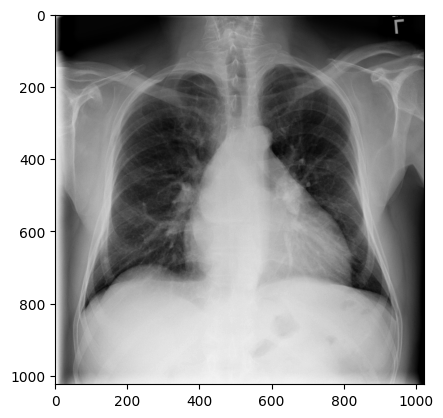

(1024, 1024)


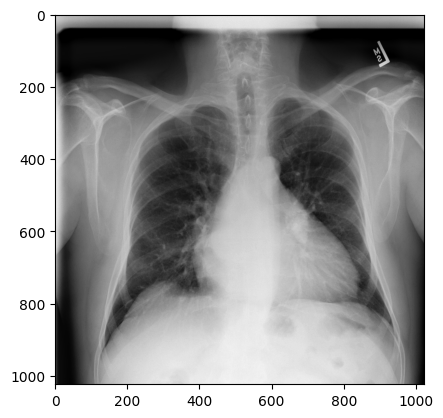

(1024, 1024)


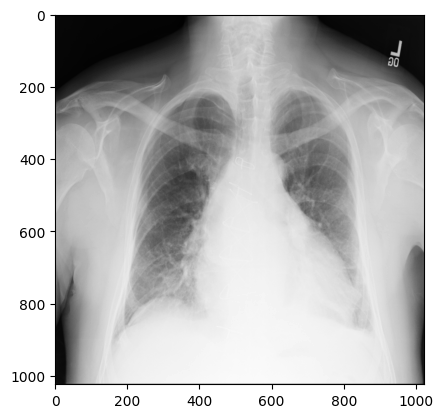

(1024, 1024)


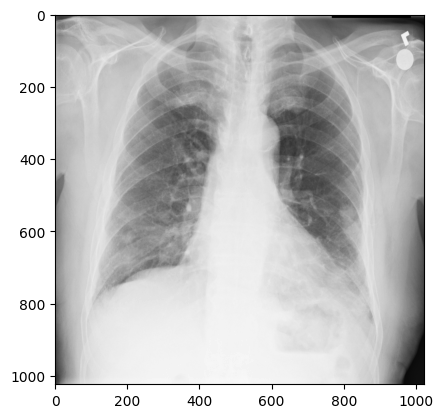

In [68]:
for index, img in enumerate(images):
  print(img.shape)
  plt.imshow(img, cmap='gray')
  plt.show()
  if index == 3:
    break

---

### split dataset

In [37]:
all_dataset = pd.read_csv(NIH_CXR14_dataset + "/NIH_CXR14_multi_hot.csv")

testing_index = "/public_bme/data/lds/CXR_datasets/NIH_chest14_dataset/test_list.txt"
training_index = "/public_bme/data/lds/CXR_datasets/NIH_chest14_dataset/train_val_list.txt"
def extract_index (file_path): 
  # 创建一个空列表来存储索引
  index_list = []

  # 打开索引文件并逐行读取
  with open(file_path, "r") as f:
      for line in f:
          # 分割每行，获取索引部分
          index_part = line.split()[0]
          # 将索引部分转换为整数，并添加到索引列表中
          index_list.append((index_part))
  # 打印索引列表
  return index_list


training_index = extract_index(training_index)
testing_index = extract_index(testing_index)

print(len(training_index))
print(len(testing_index))
len(training_index)+len(testing_index) == len(all_dataset)


86524
25596


True

In [40]:
# 假设 index_list 包含了样本名，df 是包含样本名列的 DataFrame
# 使用 isin() 方法筛选出样本名匹配的行
training_val_dataset = all_dataset[all_dataset['Image Index'].isin(training_index)]

testing_dataset = all_dataset[all_dataset['Image Index'].isin(testing_index)]
print(len(training_val_dataset))
print(len(testing_dataset))

training_val_dataset.to_csv(NIH_CXR14_dataset + "/training_val_dataset.csv", index=False)
testing_dataset.to_csv(NIH_CXR14_dataset + "/testing_dataset.csv", index=False)




86524
25596


In [13]:
print(all_dataset.shape)
print(testing_index.shape)
print(training_index.shape)

(112120, 16)
(25595, 1)
(86523, 1)


---
### dataset

In [ ]:
class NIH_CXR14_dataset(Dataset):
    def __init__(self, transform=None):
      NIH_CXR14_dataset = "/public_bme/data/lds/CXR_datasets/NIH_chest14_dataset"
      NIH_CXR14_csv = "/public_bme/data/lds/CXR_datasets/NIH_chest14_dataset/NIH_CXR14_multi_hot.csv"
      NIH_CXR14_images = "/public_bme/data/lds/CXR_datasets/NIH_chest14_dataset/images/images/" 
      self.data = pd.read_csv(NIH_CXR14_csv)
      self.root_dir = NIH_CXR14_dataset
      self.images_path = NIH_CXR14_images
      self.transform = transform
      self.images = []
      self.labels = []
      for index, row in self.data.iterrows():
        label = list(row.iloc[1:])
        self.labels.append(label)
      self.labels = np.array(self.labels)
      
      images_name = self.data["Image Index"].tolist()
      for image in tqdm(images_name):
        image_path = os.path.join(self.images_path, image)
        image = Image.open(image_path)
        self.images.append(image)
      self.images = np.array(self.images)
      
      if self.images[0].max() > 1:
        self.images = self.images / 255.0
        
        
      
    def __len__(self):
        return images.shape[0]

    def __getitem__(self, idx):
      sample = {'image': self.images[idx], 'label': self.labels[idx]}
      
dataset = NIH_CXR14_dataset()

# CheXepert

In [45]:
validation_csv  = "/public_bme/data/lds/CXR_datasets/CheXpert/data/data/CheXpert-v1.0-small/CheXpert_validation.csv"
training_csv = "/public_bme/data/lds/CXR_datasets/CheXpert/data/data/CheXpert-v1.0-small/CheXpert_training.csv"

In [47]:
validation = pd.read_csv(validation_csv)
print(validation.shape)

(169, 16)


In [51]:
training = pd.read_csv(training_csv)
training.shape

(161590, 16)

In [53]:
training


,Path,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices,Combined
0,CheXpert-v1.0-small/train/patient00001/study1/...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
1,CheXpert-v1.0-small/train/patient00002/study2/...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,"[1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, ..."
2,CheXpert-v1.0-small/train/patient00002/study1/...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ..."
3,CheXpert-v1.0-small/train/patient00003/study1/...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,CheXpert-v1.0-small/train/patient00005/study2/...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161585,CheXpert-v1.0-small/train/patient64537/study2/...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
161586,CheXpert-v1.0-small/train/patient64537/study1/...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
161587,CheXpert-v1.0-small/train/patient64538/study1/...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
161588,CheXpert-v1.0-small/train/patient64539/study1/...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
